In [3]:
!pip install python-chess
!pip install pygame

import chess
import chess.svg
import pygame
import numpy as np
from IPython.display import display, SVG
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 56.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=2f61c51ec0ef27d7ada2197e5f764740e34131db96cb790771170d76c64dba75
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess
pygame 2.6.1 (SDL 2.28.4, Python 3.11.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# --- 1. Data Preparation and Feature Engineering ---

# One-hot encode a single piece
def one_hot_encode_piece(piece):
    pieces = list('rnbqkpRNBQKP.')
    arr = np.zeros(len(pieces))
    piece_to_index = {p: i for i, p in enumerate(pieces)}
    index = piece_to_index[piece]
    arr[index] = 1
    return arr

# Encode the entire board into a 3D numpy array (8x8x13)
def encode_board(board):
    board_str = str(board).replace(' ', '').replace('\n', '')
    board_list = []
    for char in board_str:
        board_list.append(one_hot_encode_piece(char))
    return np.reshape(board_list, (8, 8, 13))


In [5]:
!pip install -q kaggle

In [6]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jksanjay","key":"4d0d11b3272da4886746c591a29b13bb"}'}

In [7]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c train-an-ai-to-play-chess

  0% 0.00/1.43M [00:00<?, ?B/s]
100% 1.43M/1.43M [00:00<00:00, 609MB/s]


In [10]:
with zipfile.ZipFile("train-an-ai-to-play-chess.zip", 'r') as zip_ref:
    zip_ref.extractall("chess_data")

In [11]:
train_df = pd.read_csv('chess_data/train.csv', index_col='id')

# We'll split the data into training and validation sets.
val_df = train_df.sample(frac=0.1, random_state=42) # Use 10% of the data for validation
train_df = train_df.drop(val_df.index) # Use the remaining 90% for training

# Encode the FEN strings in the dataframe
def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

X_train = np.stack(train_df['board'].apply(encode_fen_string))
y_train = train_df['black_score']

X_val = np.stack(val_df['board'].apply(encode_fen_string))
y_val = val_df['black_score']

In [12]:
# --- 2. More Complex Neural Network (CNN) ---
# We'll use a Convolutional Neural Network (CNN) for better spatial feature extraction.
# CNNs are well-suited for image-like data, and a chessboard can be treated as an 8x8 image.
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=(8, 8, 13)),
        Activation('relu'),
        Conv2D(32, (3, 3), padding='same'),
        Activation('relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1),
    ])
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    return model

cnn_model = create_cnn_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 158351.5469 - val_loss: 126145.0234
Epoch 2/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 133959.4219 - val_loss: 123915.3594
Epoch 3/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 124140.7422 - val_loss: 106304.1719
Epoch 4/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 113359.7031 - val_loss: 110659.2266
Epoch 5/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 100942.2422 - val_loss: 94187.1172
Epoch 6/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 92123.1250 - val_loss: 85063.9453
Epoch 7/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 92703.6641 - val_loss: 82062.0859
Epoch 8/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 84206.5469 - val_loss: 99839.7734
Epoch 9/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 74117.9141 - val_loss: 82840.7422
Epoch 10/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 77982.3828 - val_loss: 74061.1875
Epoch 11/15
1654/1654 ━━━━━━━━

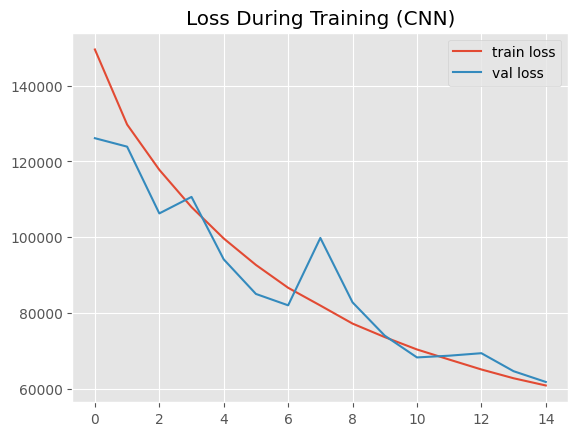

In [13]:
# Train the model
history = cnn_model.fit(
    X_train,
    y_train,
    epochs=15,
    validation_data=(X_val, y_val))

# Plot the training history
plt.style.use('ggplot')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss During Training (CNN)')
plt.show()

In [14]:
# --- 3. Search Algorithm (Minimax with Alpha-Beta Pruning) ---
# The neural network will serve as the evaluation function for our search algorithm.

def evaluate_board(board):
    """
    Evaluates the board state using the trained CNN model.
    The score is from the perspective of the current player.
    """
    encoded_board = encode_board(board)
    score = cnn_model.predict(np.array([encoded_board]), verbose=0)[0][0]

    if board.turn == chess.WHITE:
        return -score
    else:
        return score

def minimax_alpha_beta(board, depth, alpha, beta, maximizing_player):
    """
    Minimax algorithm with alpha-beta pruning.
    """
    if depth == 0 or board.is_game_over():
        return evaluate_board(board)

    if maximizing_player:
        max_eval = -np.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax_alpha_beta(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = np.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax_alpha_beta(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval

def get_ai_move(board, depth):
    """
    Gets the best move for the AI using the minimax algorithm.
    """
    best_move = None
    max_eval = -np.inf

    for move in board.legal_moves:
        board.push(move)
        eval = minimax_alpha_beta(board, depth - 1, -np.inf, np.inf, False)
        board.pop()
        if eval > max_eval:
            max_eval = eval
            best_move = move

    return best_move

In [15]:
from google.colab import files

files.upload()

Saving images.zip to images.zip


{'images.zip': b'PK\x03\x04\x14\x00\x00\x00\x08\x00\xe3K\xd8Z\x87\xb4h3y\x07\x00\x00\x89\x07\x00\x00\r\x00\x00\x00images/BB.pnguU{8\xd3\x8b\x1b\xff\x8e\x11\x13\xb5\x8a\xb9\x9c:,\xc2\x8a\x98[\xe6\xb615\xb4\xc5D8T.3s7w\xedh\xc5\xf9\xe92\x14\x8e\xb0\r\xe5:,\x99\xa1\x8b\xd4\x898#\xd7UBi9\x18I\x85\x94k~\xf3\xdf\xef\xfc\xf1{\x9f\xe7\xf3~\x9e\xf7}?\x9f\xe7\xfd\xe7}\x9e\xf7\xaa+\xe1\x84"D\x1d\x02\x00\x80\xa2\x13\x0eK\x940}\x1br`I\xa6Xp\xd0\x12\x02\x931x\x0c\x004d+l\xf8\xcbHj\xcd@\x1c\x11\x0f\x00)\x87$\xbat\x00X\xdb\xd6\xcf\x00@\xbc\x11\x00|<\x0f\x00\xa8\x02\x00\x80E\xb3\x1e\xbaYK\x06R\x01.\'\xb0\x00P\x93y\x10)\xa9\xe4\xa3q\xde\xb1\x92M\xc3\xdb\x00\xd9\xeb1\x93\x00@6\xd4\t\x8b9\x9d4:\xcf\xf2\x0eW\xf6P\xed\xba8o\xe0WZQ\xc1\xcdS\xe9p\x89\xf1?\x81u\x9566\xbb\xac\xb9\xebY\x9a\xfa\x15\xa8\xbc\xf5y\x1a\xc8t\x10Lad\x1b\xee\xea\xd8\xcd\x00\xe9L,V\xea\x17y\xe1180\xc4\x18\xc4\xd0\x04\xf3\xf7\x18\x84\xc1"\x13S\xc6\xc6\xfa3\xbe\xe7\xdb\xa7\x90\xa7\xfbX&b\xcf\xe9\x1f\x8f\xf3\x906K\x9b[&\xb1\xcd\x96d\xcd\xff

In [16]:
!unzip -q images.zip

In [17]:
# --- 4. Graphical User Interface (GUI) ---
def play_game_with_gui():
    pygame.init()
    screen = pygame.display.set_mode((600, 600))
    pygame.display.set_caption("Chess AI")
    board = chess.Board()
    board_size = 512
    square_size = board_size // 8

    def draw_board():
        for i in range(8):
            for j in range(8):
                color = (238, 238, 210) if (i + j) % 2 == 0 else (118, 150, 86)
                pygame.draw.rect(screen, color, (j * square_size, i * square_size, square_size, square_size))

    def draw_pieces():
        for i in range(8):
            for j in range(8):
                piece = board.piece_at(chess.square(j, 7 - i))
                if piece:
                    prefix = 'W' if piece.color == chess.WHITE else 'B'
                    piece_symbol = piece.symbol().upper()
                    piece_image = pygame.image.load(f"images/{prefix}{piece_symbol}.png")
                    piece_image = pygame.transform.scale(piece_image, (square_size, square_size))
                    screen.blit(piece_image, (j * square_size, i * square_size))

    running = True
    selected_square = None
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            if event.type == pygame.MOUSEBUTTONDOWN:
                x, y = event.pos
                col = x // square_size
                row = 7 - (y // square_size)
                square = chess.square(col, row)

                if selected_square is None:
                    if board.piece_at(square) and board.piece_at(square).color == board.turn:
                        selected_square = square
                else:
                    move = chess.Move(selected_square, square)
                    if move in board.legal_moves:
                        board.push(move)
                        selected_square = None
                        draw_board()
                        draw_pieces()
                        pygame.display.flip()

                        # AI's turn
                        ai_move = get_ai_move(board, depth=2)
                        if ai_move:
                            board.push(ai_move)
                    else:
                        selected_square = None

        draw_board()
        draw_pieces()
        pygame.display.flip()

        if board.is_game_over():
            print("Game Over:", board.result())
            running = False

    pygame.quit()

In [20]:
import os
import time
from IPython.display import display, clear_output
import io
from PIL import Image

def play_game_with_gui_colab(initial_board=None, ai_depth=2):
    os.environ["SDL_VIDEODRIVER"] = "dummy"

    pygame.init()
    screen = pygame.display.set_mode((600, 600))

    board = chess.Board()
    board_size = 512
    square_size = board_size // 8

    # Pre-load all piece images once for efficiency
    piece_images = {}
    piece_map = {
        (chess.PAWN, chess.WHITE): 'WP',
        (chess.KNIGHT, chess.WHITE): 'WN',
        (chess.BISHOP, chess.WHITE): 'WB',
        (chess.ROOK, chess.WHITE): 'WR',
        (chess.QUEEN, chess.WHITE): 'WQ',
        (chess.KING, chess.WHITE): 'WK',
        (chess.PAWN, chess.BLACK): 'BP',
        (chess.KNIGHT, chess.BLACK): 'BN',
        (chess.BISHOP, chess.BLACK): 'BB',
        (chess.ROOK, chess.BLACK): 'BR',
        (chess.QUEEN, chess.BLACK): 'BQ',
        (chess.KING, chess.BLACK): 'BK',
    }

    for (piece_type, color), filename_prefix in piece_map.items():
        try:
            full_filename = f"images/{filename_prefix}.png"
            piece_images[(piece_type, color)] = pygame.transform.scale(
                pygame.image.load(full_filename), (square_size, square_size)
            )
        except pygame.error:
            print(f"Warning: Could not load image {full_filename}. Make sure it exists in the 'images' folder.")

    def draw_board_and_pieces_to_screen():
        for i in range(8):
            for j in range(8):
                color = (238, 238, 210) if (i + j) % 2 == 0 else (118, 150, 86)
                pygame.draw.rect(screen, color, (j * square_size, i * square_size, square_size, square_size))

        for i in range(8):
            for j in range(8):
                piece = board.piece_at(chess.square(j, 7 - i))
                if piece:
                    key = (piece.piece_type, piece.color)
                    if key in piece_images:
                        screen.blit(piece_images[key], (j * square_size, i * square_size))
                    else:
                        print(f"Error: Image for piece {piece.symbol()} (type: {piece.piece_type}, color: {piece.color}) not found in pre-loaded dictionary.")

    print("--- Welcome to Chess AI! ---")
    player_choice = ""
    while player_choice.lower() not in ['w', 'b']:
        player_choice = input("Do you want to play as White (W) or Black (B)? ").strip().lower()
        if player_choice not in ['w', 'b']:
            print("Invalid choice. Please enter 'W' or 'B'.")

    player_is_white = (player_choice == 'w')
    print(f"You chose to play as {'White' if player_is_white else 'Black'}.")
    print(f"AI will play as {'Black' if player_is_white else 'White'}.")
    print("\nTo make a move, type it in UCI format (e.g., e2e4, g1f3) and press Enter.")
    print("Type 'quit' to end the game at any time.")


    move_count = 0
    while not board.is_game_over():
        clear_output(wait=True) # Clear previous output for animation effect

        print(f"\n--- Move {move_count + 1} ---")
        print("Current Board:")
        # Display the board using chess.svg for a clean representation
        # display(SVG(chess.svg.board(board=board, size=300)))

        # Also display the Pygame rendered board
        draw_board_and_pieces_to_screen()
        pygame.display.flip()
        img_data = pygame.image.tobytes(screen, 'RGB')
        img = Image.frombytes('RGB', (600, 600), img_data)
        with io.BytesIO() as f:
            img.save(f, format='PNG')
            f.seek(0)
            display(Image.open(f))

        time.sleep(0.1)
        current_turn_color = chess.WHITE if board.turn == chess.WHITE else chess.BLACK

        if (player_is_white and current_turn_color == chess.WHITE) or \
           (not player_is_white and current_turn_color == chess.BLACK):
            # Human's turn
            print("Your turn!")
            legal_moves_str = [move.uci() for move in board.legal_moves]
            print(f"Legal moves: {', '.join(legal_moves_str[:15])}{'...' if len(legal_moves_str) > 15 else ''}") # Show some legal moves

            user_move_str = ""
            valid_move = False
            while not valid_move:
                user_move_str = input("Enter your move (e.g., e2e4, type 'quit' to exit): ").strip()
                if user_move_str.lower() == 'quit':
                    print("Game ended by user.")
                    return # Exit the function

                try:
                    move = chess.Move.from_uci(user_move_str)
                    if move in board.legal_moves:
                        board.push(move)
                        valid_move = True
                        print(f"You played: {user_move_str}")
                    else:
                        print("Illegal move. Please try again.")
                except ValueError:
                    print("Invalid UCI format. Please try again (e.g., e2e4).")
        else:
            # AI's turn
            ai_player_color = "Black" if player_is_white else "White"
            print(f"{ai_player_color}'s turn (AI is calculating)...")
            start_time = time.time()
            ai_move = get_ai_move(board, ai_depth)
            end_time = time.time()
            print(f"AI took {end_time - start_time:.2f} seconds to calculate move.")

            if ai_move:
                print(f"AI Move: {ai_move.uci()}")
                board.push(ai_move)
            else:
                print(f"AI found no legal moves or couldn't determine a best move for {ai_player_color}.")
                if board.is_checkmate():
                    print("Game over by checkmate.")
                elif board.is_stalemate():
                    print("Game over by stalemate.")
                else:
                    print("Game over for unknown reasons or AI inability to find move.")
                break # End game if AI can't move

        move_count += 1
        time.sleep(1) # Small pause for readability between turns

    print("\n--- Game Over ---")
    print("Final Board State:")
    draw_board_and_pieces_to_screen()
    pygame.display.flip()
    img_data = pygame.image.tobytes(screen, 'RGB')
    img = Image.frombytes('RGB', (600, 600), img_data)
    with io.BytesIO() as f:
        img.save(f, format='PNG')
        f.seek(0)
        display(Image.open(f))

    print("Result:", board.result())
    pygame.quit()


--- Move 13 ---
Current Board:


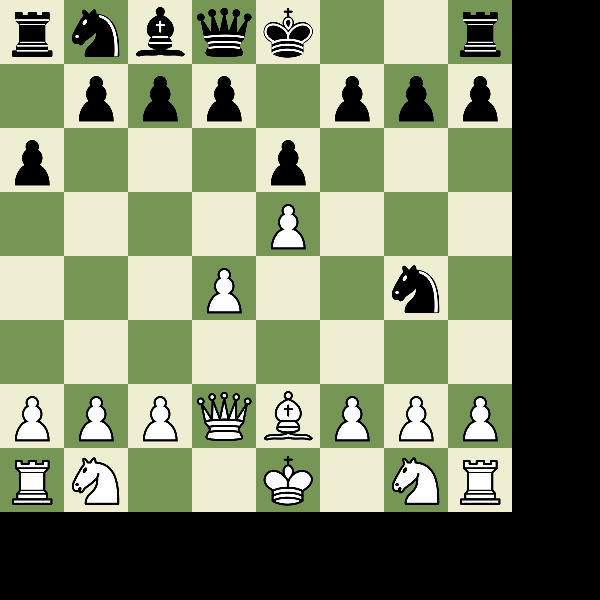

Your turn!
Legal moves: e2a6, e2b5, e2g4, e2c4, e2f3, e2d3, e2f1, e2d1, d2h6, d2g5, d2a5, d2f4, d2b4, d2e3, d2d3...
Enter your move (e.g., e2e4, type 'quit' to exit): quit
Game ended by user.


In [21]:
play_game_with_gui_colab(ai_depth=2)